In [8]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [9]:
train_dataset = torchvision.datasets.MNIST(
  root="./data",
  train=True,
  transform=torchvision.transforms.ToTensor(),
  download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=256,
    shuffle=False
)

In [11]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 400)
    self.fc2 = nn.Linear(400, 20)
    self.fc3 = nn.Linear(20, 2)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(2, 20)
    self.fc2 = nn.Linear(20, 400)
    self.fc3 = nn.Linear(400, 28 * 28)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [12]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
writer = SummaryWriter(log_dir="logs")
autoencoder

Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=20, bias=True)
    (fc3): Linear(in_features=20, out_features=2, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=400, bias=True)
    (fc3): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [13]:
def train():
  for epoch in range(500):
    autoencoder.train()
    for data in train_loader:
      img, _ = data
      img = img.view(img.size(0), -1)
      img = img.view(img.size(0), -1)
      optimizer.zero_grad()
      output = autoencoder(img)
      loss = criterion(output, img)
      loss.backward()
      optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item()}")
    writer.add_scalar("Loss/train", loss.item(), epoch)

    autoencoder.eval()
    for data in test_loader:
      img, _ = data
      img = img.view(img.size(0), -1)
      output = autoencoder(img)
      loss = criterion(output, img)
    print(f"Test Loss: {loss.item()}")
    writer.add_scalar("Loss/test", loss.item(), epoch)

In [14]:
train()

Epoch: 0, Loss: 0.06164918094873428
Test Loss: 0.06414544582366943
Epoch: 1, Loss: 0.06310460716485977
Test Loss: 0.06151212006807327
Epoch: 2, Loss: 0.06139230355620384
Test Loss: 0.06036007031798363
Epoch: 3, Loss: 0.061323944479227066
Test Loss: 0.060155969113111496
Epoch: 4, Loss: 0.05701008066534996
Test Loss: 0.05905571207404137
Epoch: 5, Loss: 0.057088010013103485
Test Loss: 0.05823907628655434
Epoch: 6, Loss: 0.058736126869916916
Test Loss: 0.05757894366979599
Epoch: 7, Loss: 0.05634934455156326
Test Loss: 0.05707907676696777
Epoch: 8, Loss: 0.056171104311943054
Test Loss: 0.056885719299316406
Epoch: 9, Loss: 0.0587204247713089
Test Loss: 0.05691345036029816
Epoch: 10, Loss: 0.05537857487797737
Test Loss: 0.053875673562288284
Epoch: 11, Loss: 0.05084041506052017
Test Loss: 0.05022561922669411
Epoch: 12, Loss: 0.0484190359711647
Test Loss: 0.04998291656374931
Epoch: 13, Loss: 0.0497019961476326
Test Loss: 0.050271373242139816
Epoch: 14, Loss: 0.04907933622598648
Test Loss: 0.050

In [15]:
torch.save(autoencoder.state_dict(), "autoencoder.pth")

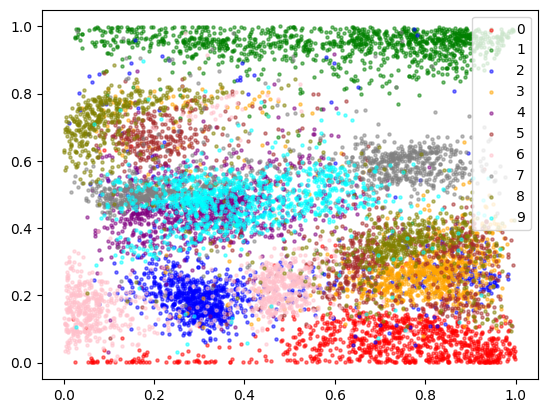

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
autoencoder.eval()
colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
x = [[] for _ in range(10)]
y = [[] for _ in range(10)]

for data in test_loader:
  img, label = data
  img = img.view(img.size(0), -1)
  encoded = autoencoder.encoder(img).detach().numpy()
  for i in range(len(label)):
    x[label[i]] = np.append(x[label[i]], encoded[i][0])
    y[label[i]] = np.append(y[label[i]], encoded[i][1])

for i in range(10):
  plt.scatter(x[i], y[i], c=colors[i], label=str(i), alpha=0.5, s=5)
plt.legend()
plt.show()
plt.savefig("out/encoded.png")

In [27]:
# エンコードしたデータをデコードして画像にする
def decode(x):
  x = torch.tensor(x).float()
  x = autoencoder.decoder(x).detach().numpy()
  x = x.reshape(28, 28)
  return x

/tmp/ipykernel_980/416172932.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("tmp.png"))


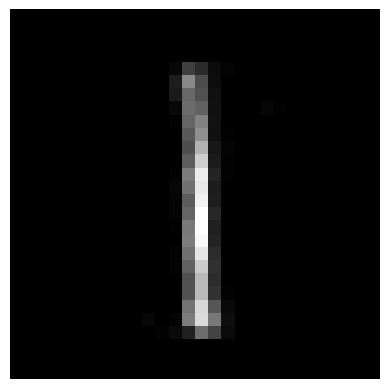

In [38]:
# [1.0, 1.0]から[0.0, 0.0]までの直線上にあるデータをデコードしてプロットし、gifにする
import imageio
x = np.linspace(1.0, 1.0, 100)
y = np.linspace(0.0, 1.0, 100)
images = []
plt.figure()
for i in range(100):
  img = decode([x[i], y[i]])
  plt.imshow(img, cmap="gray")
  plt.axis("off")
  plt.savefig("tmp.png")
  images.append(imageio.imread("tmp.png"))

imageio.mimsave("decoded3.gif", images, fps=10)
